In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## create dataset

In [2]:
train_dataset = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
)

In [3]:
test_dataset = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
)

In [4]:
print(len(train_dataset), len(test_dataset))

60000 10000


In [5]:
batch_size = 64

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

print(len(train_loader), len(test_loader))

938 157


## Build network

In [63]:
class NeuralNetwork(nn.Module):
    def __init__(self,in_dim,n_hidden_1,n_hiiden_2,out_dim):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim,n_hidden_1),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1,n_hiiden_2),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hiiden_2,out_dim),nn.ReLU(True))
    def forward(self,x):
        x=self.layer1(x)
        # print(x.shape)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

In [64]:
in_dim=28*28
n_hidden_1= 300
n_hidden_2= 100
out_dim=10

In [65]:
model=NeuralNetwork(in_dim,n_hidden_1,n_hidden_2,out_dim)

In [66]:
# model.state_dict()

In [67]:
## Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the appropriate device
print(f"Using device: {device}")

Using device: cpu


In [68]:
model =model.to(device)

In [69]:
# list(model.parameters())


## pic Loss function and Optimizer

In [74]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

## Training Loop

In [75]:
num_epochs=5

In [76]:
# Training loop
import time
num_epochs = 1
for epoch in range(num_epochs):
    print("*"*20)
    start_time = time.time()
    running_loss=0
    running_acc=0
    model.train()
    for i ,data in enumerate(train_loader,1):
        images, labels = data
        # Flatten the images
        images = images.view(images.size(0), -1)  # Flatten the images
        images, labels = images.to(device), labels.to(device)        
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        # running_acc += (predicted == labels).sum().item()
        running_acc += (predicted == labels).float().mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {running_acc / i:.4f}")
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {end_time - start_time:.2f} seconds, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {running_acc / len(train_loader):.4f}")


********************


Epoch [1/1], Step [100/938], Loss: 1.2394, Accuracy: 0.5816
Epoch [1/1], Step [200/938], Loss: 1.0536, Accuracy: 0.6107
Epoch [1/1], Step [300/938], Loss: 0.9723, Accuracy: 0.6206
Epoch [1/1], Step [400/938], Loss: 0.8491, Accuracy: 0.6304
Epoch [1/1], Step [500/938], Loss: 0.9281, Accuracy: 0.6368
Epoch [1/1], Step [600/938], Loss: 0.9686, Accuracy: 0.6398
Epoch [1/1], Step [700/938], Loss: 1.0897, Accuracy: 0.6440
Epoch [1/1], Step [800/938], Loss: 1.1204, Accuracy: 0.6454
Epoch [1/1], Step [900/938], Loss: 0.7794, Accuracy: 0.6473
Epoch [1/1] completed in 34.91 seconds, Loss: 0.9538, Accuracy: 0.6478


In [77]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    print("*" * 20)
    start_time = time.time()
    running_loss = 0
    total_correct = 0
    total_samples = 0

    model.train()
    for i, data in enumerate(train_loader, 1):
        images, labels = data
        images = images.view(images.size(0), -1)  # Flatten the images
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        # print(outputs, labels.data,outputs.shape)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        # print(total_correct, total_samples)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            accuracy = total_correct / total_samples
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], "f"Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    end_time = time.time()
    # print(f"Outputs : {outputs}")
    # print(f"Outputs Data : {outputs.data}")
    print(total_correct, total_samples)
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = total_correct / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {end_time - start_time:.2f} seconds, "f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    model.eval()  #for checking how good is your model on the test dataset  (for evaluation )
    eval_loss = 0.
    eval_acc = 0.
    # start_time = time.time()
    for data in test_loader:
        img, label = data
        img = img.view(img.size(0), -1)
        img=img.to(device)
        label=label.to(device)
        with torch.no_grad(): # because here we do not need gradients because we are just testing our model,
            out = model(img)
            loss = criterion(out, label)
        eval_loss += loss.item()
        _, pred = torch.max(out, 1) #getting prediction from our model for testing the result
        eval_acc += (pred == label).float().mean()
    print(f'Test Loss: {eval_loss/len(test_loader):.6f}, Acc: {eval_acc/len(test_loader):.6f}')
    print(f'Time:{(time.time()-start_time):.1f} s')


********************
Epoch [1/5], Step [100/938], Loss: 0.8998, Accuracy: 0.6630
Epoch [1/5], Step [200/938], Loss: 0.8322, Accuracy: 0.6690
Epoch [1/5], Step [300/938], Loss: 0.7223, Accuracy: 0.6741
Epoch [1/5], Step [400/938], Loss: 0.9081, Accuracy: 0.6740
Epoch [1/5], Step [500/938], Loss: 0.5509, Accuracy: 0.6727
Epoch [1/5], Step [600/938], Loss: 1.0350, Accuracy: 0.6737
Epoch [1/5], Step [700/938], Loss: 0.6597, Accuracy: 0.6748
Epoch [1/5], Step [800/938], Loss: 0.7943, Accuracy: 0.6748
Epoch [1/5], Step [900/938], Loss: 0.8649, Accuracy: 0.6756
40525 60000
Epoch [1/5] completed in 36.83 seconds, Loss: 0.8167, Accuracy: 0.6754
Test Loss: 0.799713, Acc: 0.681131
Time:41.0 s
********************
Epoch [2/5], Step [100/938], Loss: 1.0054, Accuracy: 0.6828
Epoch [2/5], Step [200/938], Loss: 0.8508, Accuracy: 0.6845
Epoch [2/5], Step [300/938], Loss: 0.7745, Accuracy: 0.6835
Epoch [2/5], Step [400/938], Loss: 0.8428, Accuracy: 0.6814
Epoch [2/5], Step [500/938], Loss: 0.7680, Accur

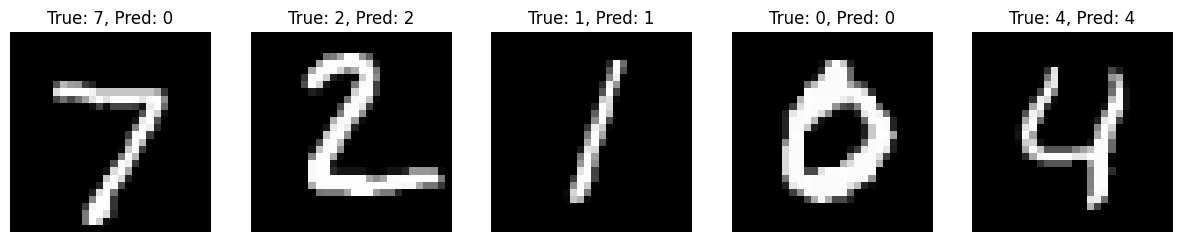

In [78]:
# Visualizing some predictions
images, labels = next(iter(test_loader))
images = images.reshape(-1, 28*28).to(device)
labels = labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
#fig is a reference to the entire figure.
#ax is an array of Axes objects, and each Axes object can be used to draw a plot. Since there are 5 subplots, ax contains 5 such objects.
#figsize=(15, 3) sets the size of the entire figure to 15 inches wide and 3 inches tall.
fig, ax = plt.subplots(1, 5, figsize=(15, 3)) #The arguments (1, 5) specify that the figure should have 1 row of 5 columns, i.e., 5 subplots aligned horizontally.
for i in range(5):
    ax[i].imshow(images[i].reshape(28, 28).cpu(), cmap='gray')
    ax[i].set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
    ax[i].axis('off')
plt.show()